In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import seaborn as sns

In [2]:
# Read in diffsel, dmso, and synon data

diffsel_df = pd.read_csv('../utils/diffsel_calib.csv', index_col=0)

dmso_df = pd.read_csv('../utils/point_muts_calib.csv', index_col=0, header=[0,1])
dmso_df.rename(dict(zip(dmso_df.index.tolist(), diffsel_df.index.tolist())), inplace=True)

synon_zero_df = pd.read_csv('../utils/synon_df.csv', index_col=0, header=[0,1])

synon_diffsel = np.genfromtxt('../utils/synon_diffsel_calib.txt', delimiter=',')

diffsel_map = pd.read_csv('../utils/diffsel_calib_map.csv', index_col=0)


In [3]:
# assign positions to diffsel
pos_list = []
for variant in diffsel_df.index.tolist():
    if '_' in variant:
        pos_list.append(np.nan)
    else:
        pos = variant[1:-1]
        pos_list.append(int(pos))
diffsel_df['position'] = pos_list

In [4]:
# Define cutoffs for GOF activity and strong client

dmso_cutoff = np.nanmean(synon_zero_df.values) + 1.3 * np.nanstd(synon_zero_df.values)
diffsel_cutoff = np.nanmean(synon_diffsel) - 2 * np.nanstd(synon_diffsel)

In [5]:
lof_cutoff = (np.nanmean(synon_zero_df.values) - 1.3 * np.nanstd(synon_zero_df.values))
act_cutoff = (np.nanmean(synon_diffsel) + 2 * np.nanstd(synon_diffsel))

In [6]:
client_idx = (diffsel_df['diffsel'] < diffsel_cutoff).values

dmso_vals = dmso_df[('Zero', 'score')]
rad_vals = dmso_df[('Radicicol', 'score')]

In [7]:
# Read in ddG, SASA, and conservation DFs
# Open is 0, closed is 1
sasa_arr = np.genfromtxt('../utils/sc_sasa_arr.txt', delimiter=',')
sasa_df = pd.DataFrame(sasa_arr.T, index=diffsel_df.index.tolist(), columns=['closed','open'])

# hSASA
hsasa = pd.read_csv('../utils/hsasa_df.csv', index_col=0)

# Read in other Rosetta metrics
inactive_fl = pd.read_csv('../utils/prims_rosetta_XXX_2src_human_FL_gap-shifted.txt', skiprows=22, index_col=0, delimiter=' ')
inactive_cd = pd.read_csv('../utils/prims_rosetta_XXX_2src_human_CD_gap-shifted.txt', skiprows=22, index_col=0, delimiter=' ')
active_fl = pd.read_csv('../utils/prims_rosetta_XXX_1y57_human_FL_gap-shifted.txt', skiprows=22, index_col=0, delimiter=' ')
active_cd = pd.read_csv('../utils/prims_rosetta_XXX_1y57_human_CD_gap-shifted.txt', skiprows=22, index_col=0, delimiter=' ')


# Coevolution values
coevo_df = pd.read_csv('../utils/coevo_df.csv', index_col=0)


In [8]:
# Define aF pocket positions from EA paper
af_pocket_pos = [378, 381, 443, 444, 506, 508, 511, 512]


# Get adjacent positions
from Bio import PDB

parser = PDB.PDBParser()
io = PDB.PDBIO()
struct = parser.get_structure('CA','../utils/CA.txt')

coords = []
resis = []
prev_res = None
for model in struct:
    for chain in model:
        for residue in chain:
            resn = residue.get_id()[1]
            resis.append(resn)
            if prev_res is not None:
                if resn - prev_res > 1:
                    print(resn)
            prev_res = resn        
            
            for atom in residue:
                x,y,z = atom.get_coord()
                coords.append(np.array([x, y, z]))

resis = np.array(resis)
resis = resis[:250]
coords = np.array(coords)
coords = coords[:250, :]

# Calculate distance matrix
from scipy.spatial import distance_matrix
dist_mat = distance_matrix(coords, coords)

# Get atoms within XX defined angstroms of aF pocket alpha carbons
angstrom_cutoff = 7
adjacent_resis = []
idxer = -270
for pos in af_pocket_pos:
    idx = pos + idxer
    adj_pos = resis[dist_mat[pos - 270, :] < angstrom_cutoff]
    for pos2 in adj_pos:
        if pos2 not in adjacent_resis and pos2 not in af_pocket_pos:
            adjacent_resis.append(pos2)

print('color gray80, 2src_kinDom')
print('select af_pocket, resi ' + '+'.join([str(x) for x in af_pocket_pos]))
print('color red, af_pocket')
print('select adj_pos, resi ' + '+'.join([str(x) for x in adjacent_resis]))
print('color salmon, adj_pos')

531
color gray80, 2src_kinDom
select af_pocket, resi 378+381+443+444+506+508+511+512
color red, af_pocket
select adj_pos, resi 374+375+376+377+379+380+382+513+383+384+385+386+441+442+445+446+447+448+503+504+505+507+509+510+514+515+516
color salmon, adj_pos


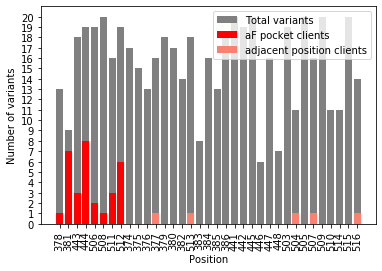

In [9]:
# Count number of variants and clients at each position and make a bar chart
af_vars = []
af_clients = []
adj_vars = []
adj_clients = []

for pos in af_pocket_pos:
    n_vars = np.sum(~diffsel_map.loc[pos].isnull())
    n_clients = np.sum(diffsel_map.loc[pos]  < diffsel_cutoff)
    af_vars.append(n_vars)
    af_clients.append(n_clients)
    
for pos in adjacent_resis:
    n_vars = np.sum(~diffsel_map.loc[pos].isnull())
    n_clients = np.sum(diffsel_map.loc[pos]  < diffsel_cutoff)
    adj_vars.append(n_vars)
    adj_clients.append(n_clients)
    
bar_pos = np.arange(len(af_vars + adj_vars))
plt.bar(bar_pos, (af_vars + adj_vars), label='Total variants', color='grey')
plt.bar(bar_pos[:len(af_pocket_pos)], af_clients, label='aF pocket clients', color='red')
plt.bar(bar_pos[len(af_pocket_pos):], adj_clients, label='adjacent position clients', color='salmon')
plt.xticks(bar_pos, list(af_pocket_pos) + list(adjacent_resis), rotation=90)
plt.yticks(np.arange(21), np.arange(21))
plt.legend()
plt.xlabel('Position')
plt.ylabel('Number of variants')
plt.show()


In [10]:
pos_list = af_pocket_pos + adjacent_resis
pos_list.sort()

n_vars = []
n_clients = []
class_list = []
for pos in pos_list:
    pos_df = diffsel_df[diffsel_df['position'] == pos]
    pos_clients = sum(pos_df['diffsel'] < diffsel_cutoff)
    
    n_vars.append(len(pos_df))
    n_clients.append(pos_clients)
    
    if pos in af_pocket_pos:
        class_list.append('ɑF pocket')
    else:
        class_list.append('Adjacent')

In [11]:
af_df = pd.DataFrame(np.array([class_list, n_vars, n_clients]).T, index=pos_list, columns=['Class', 'n variants', 'n clients'])

In [12]:
# Do a Fisher's exact test to see if the proportions are different
af_fisher_arr = [[sum(af_vars) - sum(af_clients), sum(af_clients)], [sum(adj_vars) - sum(adj_clients), sum(adj_clients)]]
import scipy.stats as stats
oddsratio, pvalue = stats.fisher_exact(af_fisher_arr)
print('p-value of Fisher\'s exact test for different in proportion: {}'.format(pvalue))

p-value of Fisher's exact test for different in proportion: 6.691035246165697e-16


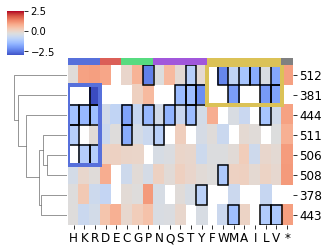

In [13]:
# Heatmap for phenomenology
af_pocket_map_clustering = diffsel_map.loc[af_pocket_pos].copy()
af_pocket_map_clustering = af_pocket_map_clustering[['H', 'K', 'R', 'D', 'E', 'C', 'G', 'P',
                                                    'N', 'Q', 'S', 'T', 'Y', 'F', 'W', 'M', 'A', 'I',
                                                    'L', 'V', '*']]
af_clust_mask = af_pocket_map_clustering.isnull()
af_pocket_map_clustering.fillna(0, inplace=True)
af_map_bool = af_pocket_map_clustering < diffsel_cutoff

sns_palette = sns.color_palette("hls", 8).as_hex()
lut = {
    'H' : sns_palette[5],
    'K' : sns_palette[5],
    'R' : sns_palette[5],
    'D' : sns_palette[0],
    'E' : sns_palette[0],
    'C' : sns_palette[3],
    'M' : sns_palette[1],
    'N' : sns_palette[-2],
    'Q' : sns_palette[-2],
    'S' : sns_palette[-2],
    'T' : sns_palette[-2],
    'A' : sns_palette[1],
    'I' : sns_palette[1],
    'L' : sns_palette[1],
    'V' : sns_palette[1],
    'F' : sns_palette[1],
    'W' : sns_palette[1],
    'Y' : sns_palette[-2],
    'G' : sns_palette[3],
    'P' : sns_palette[3],
    '*' : 'grey'  
}
col_colors = af_pocket_map_clustering.columns.map(lut)
from matplotlib.patches import Rectangle

width = 116 / 25.4
height = 87 / 25.4

g = sns.clustermap(af_pocket_map_clustering,
                      vmin=-3,
                      vmax=2.5,
                      cmap='coolwarm',
                      mask=af_clust_mask,
                      col_cluster=False,
                      col_colors=col_colors,
                   figsize=(width, height),
                   xticklabels=1
                  )
ax = g.ax_heatmap
g_reorder = g.data.loc[[512, 381, 444, 511, 506, 508 ,378 ,443], :]
for i in np.arange(g.data.shape[0]):
    for j in np.arange(g.data.shape[1]):
        if (g_reorder.values[i, j] < diffsel_cutoff):
            ax.add_patch(Rectangle((j, i), 1, 1, fill=False, edgecolor='k', lw=1.5))

ax.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 12, rotation=0)
ax.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 12)

ax.add_patch(Rectangle((0,1), 3, 4, fill=False, edgecolor=sns_palette[5], lw=4))
ax.add_patch(Rectangle((13,0), 7, 2, fill=False, edgecolor=sns_palette[1], lw=4))



In [14]:
g.savefig('f4c.png', dpi=300)

In [15]:
b1b2_pos = [273, 274, 275, 283, 285, 286]
blue_col = np.array([20, 199, 222]) / 255
# Get atoms within XX defined angstroms of aF pocket alpha carbons
angstrom_cutoff = 7
adjacent_resis = []
idxer = -270
for pos in b1b2_pos:
    idx = pos + idxer
    adj_pos = resis[dist_mat[pos - 270, :] < angstrom_cutoff]
    for pos2 in adj_pos:
        if pos2 not in adjacent_resis and pos2 not in b1b2_pos:
            adjacent_resis.append(pos2)

print('color gray80, 2src_kinDom')
print('select b1b2_pos, resi ' + '+'.join([str(x) for x in b1b2_pos]))
print('set_color cdblue, [0.07843137, 0.78039216, 0.87058824]')
print('color cdblue, b1b2_pos')

color gray80, 2src_kinDom
select b1b2_pos, resi 273+274+275+283+285+286
set_color cdblue, [0.07843137, 0.78039216, 0.87058824]
color cdblue, b1b2_pos


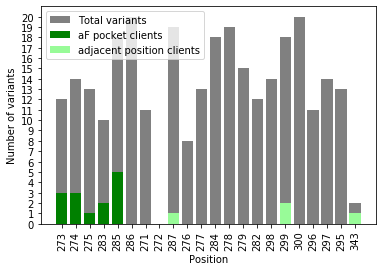

In [16]:
# Count number of variants and clients at each position and make a bar chart
b1b2_vars = []
b1b2_clients = []
adj_vars = []
adj_clients = []

for pos in b1b2_pos:
    n_vars = np.sum(~diffsel_map.loc[pos].isnull())
    n_clients = np.sum(diffsel_map.loc[pos]  < diffsel_cutoff)
    b1b2_vars.append(n_vars)
    b1b2_clients.append(n_clients)
    
for pos in adjacent_resis:
    n_vars = np.sum(~diffsel_map.loc[pos].isnull())
    n_clients = np.sum(diffsel_map.loc[pos]  < diffsel_cutoff)
    adj_vars.append(n_vars)
    adj_clients.append(n_clients)
    
bar_pos = np.arange(len(b1b2_vars + adj_vars))
plt.bar(bar_pos, (b1b2_vars + adj_vars), label='Total variants', color='grey')
plt.bar(bar_pos[:len(b1b2_pos)], b1b2_clients, label='aF pocket clients', color='green')
plt.bar(bar_pos[len(b1b2_pos):], adj_clients, label='adjacent position clients', color='palegreen')
plt.xticks(bar_pos, list(b1b2_pos) + list(adjacent_resis), rotation=90)
plt.yticks(np.arange(21), np.arange(21))
plt.legend()
plt.xlabel('Position')
plt.ylabel('Number of variants')
plt.show()

In [17]:
pos_list = b1b2_pos + adjacent_resis
pos_list.sort()

n_vars = []
n_clients = []
class_list = []
for pos in pos_list:
    pos_df = diffsel_df[diffsel_df['position'] == pos]
    pos_clients = sum(pos_df['diffsel'] < diffsel_cutoff)
    
    n_vars.append(len(pos_df))
    n_clients.append(pos_clients)
    
    if pos in b1b2_pos:
        class_list.append('B1B2 strands')
    else:
        class_list.append('Adjacent')

In [18]:
b1b2_df = pd.DataFrame(np.array([class_list, n_vars, n_clients]).T, index=pos_list, columns=['Class', 'n variants', 'n clients'])

In [19]:
# Do a Fisher's exact test to see if the proportions are different
b1b2_fisher_arr = [[sum(b1b2_vars) - sum(b1b2_clients), sum(b1b2_clients)], [sum(adj_vars) - sum(adj_clients), sum(adj_clients)]]
oddsratio, pvalue = stats.fisher_exact(b1b2_fisher_arr)
print('p-value of Fisher\'s exact test for different in proportion: {}'.format(pvalue))

p-value of Fisher's exact test for different in proportion: 1.7905858641169683e-05


[Text(1, 0.5, '285'),
 Text(1, 1.5, '275'),
 Text(1, 2.5, '283'),
 Text(1, 3.5, '273'),
 Text(1, 4.5, '274'),
 Text(1, 5.5, '286')]

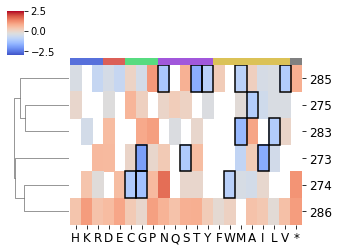

In [20]:
# Heatmap for phenomenology
b1b2_map_clustering = diffsel_map.loc[b1b2_pos].copy()
b1b2_map_clustering = b1b2_map_clustering[['H', 'K', 'R', 'D', 'E', 'C', 'G', 'P',
                                                    'N', 'Q', 'S', 'T', 'Y', 'F', 'W', 'M', 'A', 'I',
                                                    'L', 'V', '*']]
b1b2_clust_mask = b1b2_map_clustering.isnull()
b1b2_map_clustering.fillna(0, inplace=True)
b1b2_map_bool = b1b2_map_clustering < diffsel_cutoff

sns_palette = sns.color_palette("hls", 8).as_hex()
lut = {
    'H' : sns_palette[5],
    'K' : sns_palette[5],
    'R' : sns_palette[5],
    'D' : sns_palette[0],
    'E' : sns_palette[0],
    'C' : sns_palette[3],
    'M' : sns_palette[1],
    'N' : sns_palette[-2],
    'Q' : sns_palette[-2],
    'S' : sns_palette[-2],
    'T' : sns_palette[-2],
    'A' : sns_palette[1],
    'I' : sns_palette[1],
    'L' : sns_palette[1],
    'V' : sns_palette[1],
    'F' : sns_palette[1],
    'W' : sns_palette[1],
    'Y' : sns_palette[-2],
    'G' : sns_palette[3],
    'P' : sns_palette[3],
    '*' : 'grey'  
}
col_colors = b1b2_map_clustering.columns.map(lut)
from matplotlib.patches import Rectangle

g = sns.clustermap(b1b2_map_clustering,
                      vmin=-3,
                      vmax=2.5,
                      cmap='coolwarm',
                      mask=b1b2_clust_mask,
                      col_cluster=False,
                      col_colors=col_colors,
                    figsize=(width, height),
                    xticklabels=1)
ax = g.ax_heatmap
g_reorder = g.data.loc[[285, 275, 283, 273, 274, 286], :]
for i in np.arange(g.data.shape[0]):
    for j in np.arange(g.data.shape[1]):
        if (g_reorder.values[i, j] < diffsel_cutoff):
            ax.add_patch(Rectangle((j, i), 1, 1, fill=False, edgecolor='k', lw=1.5))

ax.set_xticklabels(g.ax_heatmap.get_xmajorticklabels(), fontsize = 12, rotation=0)
ax.set_yticklabels(g.ax_heatmap.get_ymajorticklabels(), fontsize = 12, rotation=0)


In [21]:
g.savefig('f4d.png', dpi=300)